# Sonar Navigation

While recently exploring a potential employment opportunity with a defense contractor, the subject of "Mine & Obstacle Avoidance Sonar" (MOAS) systems was raised, which naturally sparked my curiosity on how machine learning could be applied to such a domain.  I was therefore pleasantly surprised to come across the <a href="https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)">"Sonar, Mines vs. Rocks" data set</a> while browsing the <a href="https://archive.ics.uci.edu/ml/index.php">UCI Machine Learning Repository</a>. 

The main challenge addressed by this project is to predict metal or rock objects from sonar return data.  Each row in the data set is a pattern consisting of a set of 60 numbers in the range 0.0 to 1.0.  Each number represents the energy within a particular frequency band, integrated over a certain period of time.  The label associated with each record contains the letter R if the object is a rock and M if it is a mine (metal cylinder).  The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly.

A common problem I frequently struggle with is trying to anticipate which algorithms will perform the best, so a particular emphasis will be placed on evaluating a suite of algorithms suitable for a binary classification problem like this one.  The general idea will be to perform a baseline evaluation of this suite, and then to identify potential transformations and tuning opportunities for improving performance, as well as to employ suitable ensemble methods to make a final algorithm selection in order to arrive at a finalized model.

In this particular case, I found it quite interesting that my initial intuition that distance-based algorithms would perform relatively well turned out to be correct...

## Library Versions

- Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
- NumPy version: 1.20.1
- Pandas version: 1.2.4
- Matplotlib version: 3.3.4
- Seaborn version: 0.11.1
- Scikit-Learn version: 0.24.1

## Library Imports

In [1]:
import numpy as np
from matplotlib import pyplot
from pandas import set_option
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

First, we'll download the data set to the local project directory and name it with a '.csv' extension, so the format will be obvious to all.

We won't bother to specify header names, since the variables involved don't really have meaningful names, and adding names like "energy in frequency band 1/2/3/etc" wouldn't add much to anybody's understanding of the data.

In [2]:
url = 'sonar.all-data.csv'
dataset = read_csv(url, header=None)

## Exploratory Analysis

In [3]:
print(dataset.shape)

(208, 61)


As expected, we have 208 observations with 61 attributes each, including the class attribute.  Now, let's check the data types of our attributes...

In [4]:
set_option('display.max_rows', 500)
print(dataset.dtypes)

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
31    float64
32    float64
33    float64
34    float64
35    float64
36    float64
37    float64
38    float64
39    float64
40    float64
41    float64
42    float64
43    float64
44    float64
45    float64
46    float64
47    float64
48    float64
49    float64
50    float64
51    float64
52    float64
53    float64
54    float64
55    float64
56    float64
57    float64
58    float64
59    float64
60     object
dtype: object


All attributes are numeric, except for the class attribute, which is read as an object...let's take a quick peek at the first 30 rows...

In [5]:
set_option('display.width', 100)
print(dataset.head(30))

        0       1       2       3       4       5       6       7       8       9   ...      51  \
0   0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109  0.2111  ...  0.0027   
1   0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337  0.2872  ...  0.0084   
2   0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598  0.6194  ...  0.0232   
3   0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598  0.1264  ...  0.0121   
4   0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564  0.4459  ...  0.0031   
5   0.0286  0.0453  0.0277  0.0174  0.0384  0.0990  0.1201  0.1833  0.2105  0.3039  ...  0.0045   
6   0.0317  0.0956  0.1321  0.1408  0.1674  0.1710  0.0731  0.1401  0.2083  0.3513  ...  0.0201   
7   0.0519  0.0548  0.0842  0.0319  0.1158  0.0922  0.1027  0.0613  0.1465  0.2838  ...  0.0081   
8   0.0223  0.0375  0.0484  0.0475  0.0647  0.0591  0.0753  0.0098  0.0684  0.1487  ...  0.0145   
9   0.0164

It's nice to see that all the displayed numeric attributes are of the same scale, which seems to confirm the range indicated in the data set documentation (0 to 1).  It also becomes obvious that the class attribute, which was read as an object when we enumerated the types above, contains string values.

In [6]:
print(dataset.describe())

               0           1           2           3           4           5           6   \
count  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000  208.000000   
mean     0.029164    0.038437    0.043832    0.053892    0.075202    0.104570    0.121747   
std      0.022991    0.032960    0.038428    0.046528    0.055552    0.059105    0.061788   
min      0.001500    0.000600    0.001500    0.005800    0.006700    0.010200    0.003300   
25%      0.013350    0.016450    0.018950    0.024375    0.038050    0.067025    0.080900   
50%      0.022800    0.030800    0.034300    0.044050    0.062500    0.092150    0.106950   
75%      0.035550    0.047950    0.057950    0.064500    0.100275    0.134125    0.154000   
max      0.137100    0.233900    0.305900    0.426400    0.401000    0.382300    0.372900   

               7           8           9   ...          50          51          52          53  \
count  208.000000  208.000000  208.000000  ...  208.000000  208.

The summary of each attribute confirms the expected range, but it's interesting that there seems to be quite a bit of variation in the mean values.  This suggests that standardizing the data could yield benefits for certain algorithms.

In [7]:
print(dataset.groupby(60).size())

60
M    111
R     97
dtype: int64


Thankfully, the classes seem to be reasonably balanced between 'M' (mines) and 'R' (rocks), and the enumeration of class values confirms the binary classification task indicated by the data set documentation.

Now for some histograms of each attribute to get a sense of the distributions...

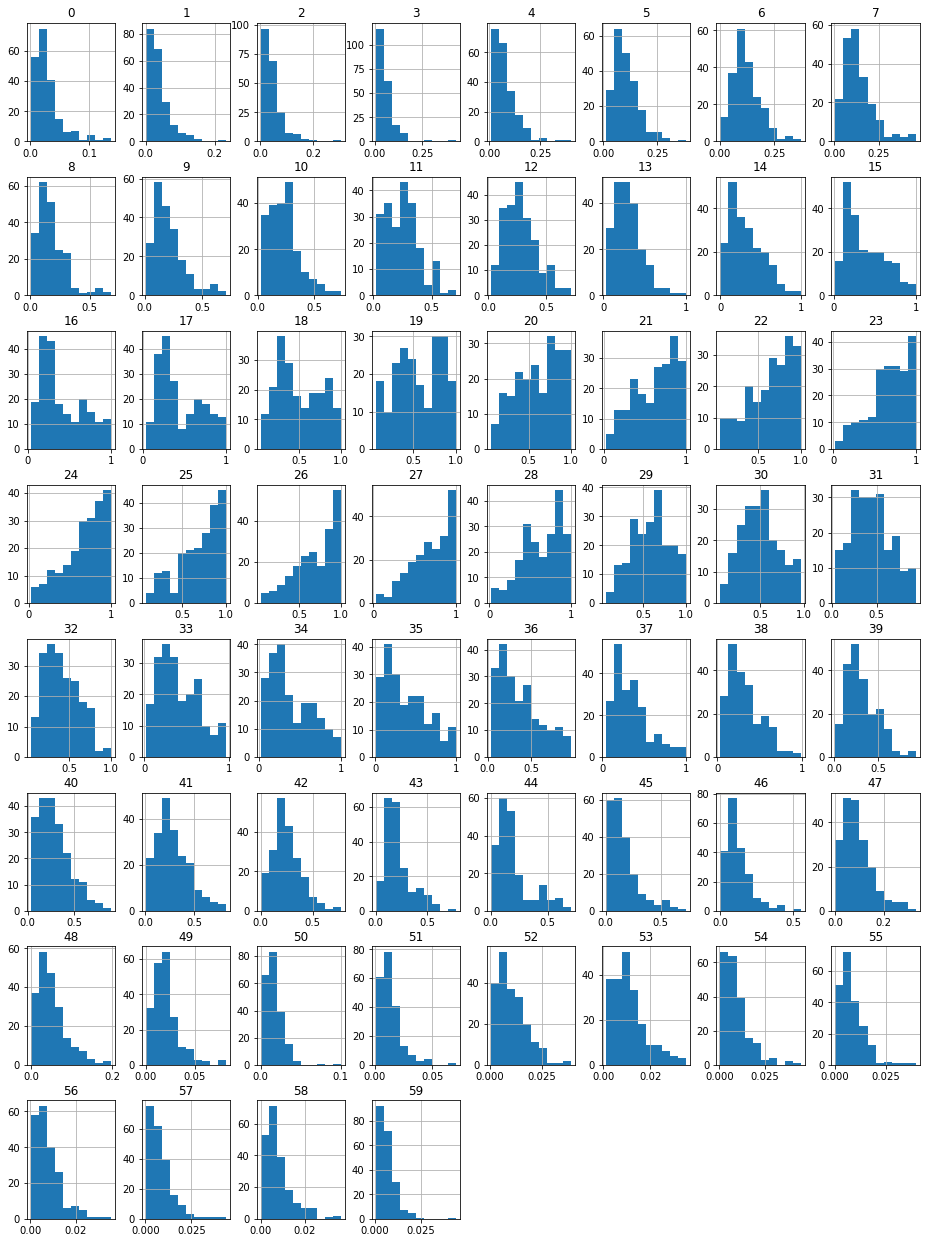

In [8]:
dataset.hist(figsize=(16,22))
pyplot.show()

There seem to be quite a few Gaussion-type distributions, as well as those that are more exponential...

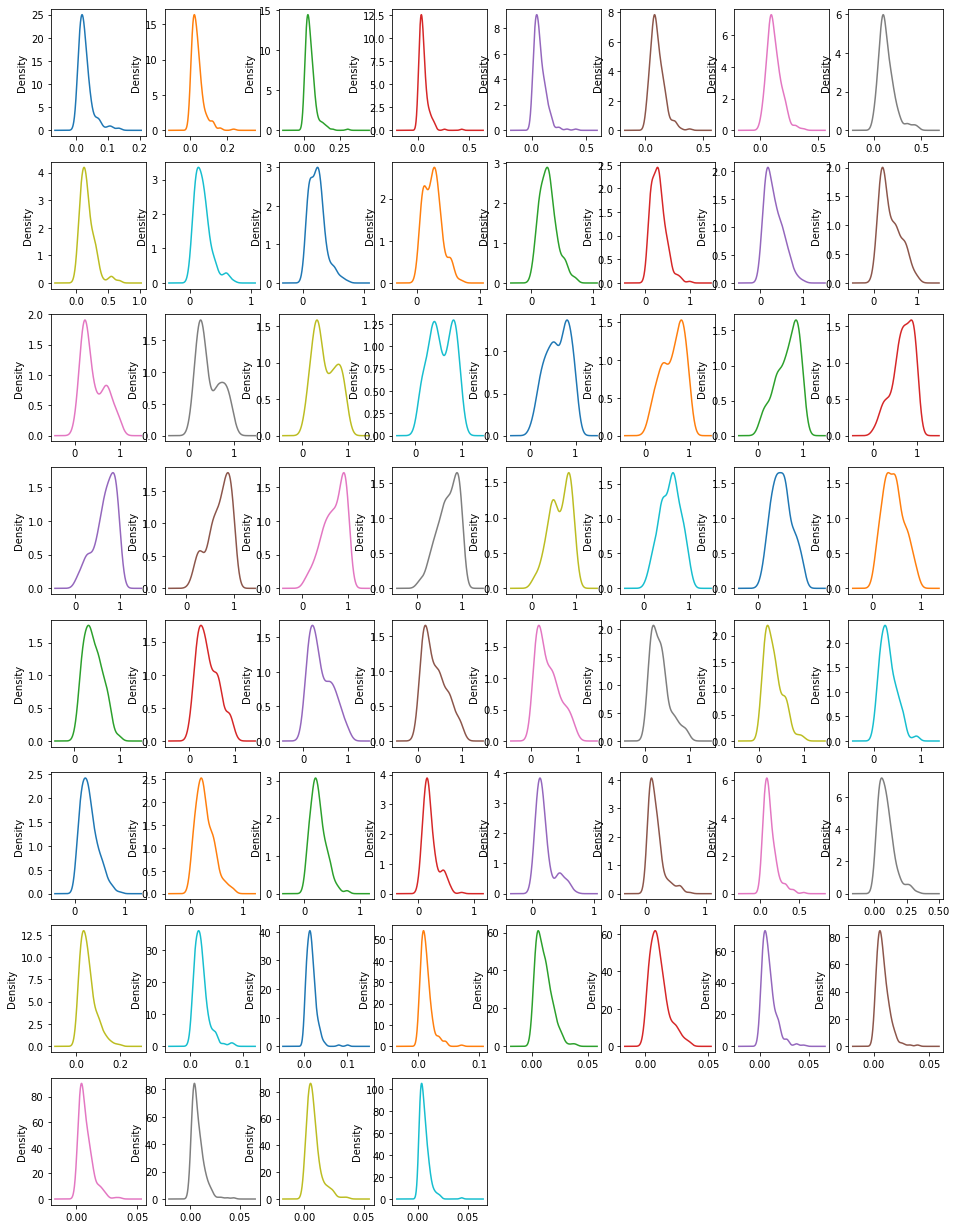

In [9]:
dataset.plot(kind='density', subplots=True, layout=(8,8), sharex=False, legend=False, figsize=(16,22))
pyplot.show()

The density plots of each attribute are very useful, since we can see that many of the attributes have a skewed distribution.  Perhaps some transformations that can correct for the skew might be in order...

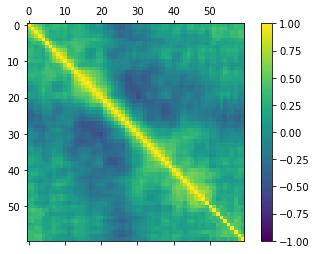

In [10]:
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
pyplot.show()

A look at the correlation matrix of the various attributes reveals that there seems to be some structure to the order of the attributes.  The yellow around the diagonal suggests that attributes that are next to each other are generally more correlated with each other. The blue patches also suggest some moderate negative correlation the further attributes are away from each other in the ordering. This makes sense if the order of the attributes refers to the angle of sensors for the sonar chirp.

## Data Cleaning

As revealed by the initial analysis, the data set chosen for this project seems to be quite clean already, so no further cleaning appears to be necessary.

## Feature Engineering

Given the nature of the data set, engineering new features doesn't seem to be possible without further information.

## Algorithm Selection

The algorithms to be added to the suite must obviously be suitable for binary classification, and for the sake of comprehensiveness, should include both linear and non-linear algorithms.  Here is an initial list of suitable algorithms that will be used in this project:

- Logistic Regression
- Linear Discriminant Analysis
- Naive Bayes
- Decision Trees
- Support Vector Machines
- K-Nearest Neighbors

The first two are obviously linear algorithms, and the remainder are non-linear, with several of them being capable of supporting not only binary classification, but multiclass classification as well.

An attempt was also made to preserve a balance between parametric (top 3) and non-parametric (bottom 3) algorithms, so we can see if the form of the function assumed or selected by the parametric algorithms are a limiting factor or not. 

As mentioned in the introduction, my initial intuition is that distance-based algorithms like support vector machines or k-nearest neighbors will perform well given the nature of the data set, so we'll keep a close eye on these as we proceed.

## Model Training

A baseline evaluation of the algorithms described above will be performed, so we can compare the effects of data transformation and hyperparameter tuning against it.

First, we'll set aside 20% of our data and reserve it for testing and validation.  To ensure a roughly equal allocation of observations for each class, we'll stratify based on the classifiers...

In [11]:
array = dataset.values
X = array[:,0:60].astype(float)
Y = array[:,60]
test_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=test_size, random_state=seed, stratify=Y)

Let's take a quick peek at the results of our split...

In [12]:
unique, frequency = np.unique(Y_validation, return_counts = True)
print("Test Values:", unique)
print("Test Frequencies:", frequency)
unique, frequency = np.unique(Y_train, return_counts = True)
print("Train Values:", unique)
print("Train Frequencies:", frequency)

Test Values: ['M' 'R']
Test Frequencies: [22 20]
Train Values: ['M' 'R']
Train Frequencies: [89 77]


Looks good!  Next, we'll create an array of the algorithms described in the 'Algorithm Selection' section above...

In [13]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('KNN', KNeighborsClassifier()))

Our baseline evaluation will use default tuning parameters for all algorithms, and the training data set will be resampled with 10 fold cross validation so we can estimate performance with less variance than if we just used a single train-test split.

Since we have a balanced number of observations in each class, and all predictions and prediction errors are equally important in our model, performance will be measured using the accuracy metric, with the mean and standard deviation of accuracy for each algorithm printed out for comparison.

In [14]:
num_folds = 10
scoring = 'accuracy'

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.753309 (0.071393)
LDA: 0.729412 (0.102602)
NB: 0.686397 (0.066034)
CART: 0.727941 (0.129201)
SVM: 0.806985 (0.083469)
KNN: 0.748162 (0.116205)


As expected, the mean accuracy values suggest that the distance-based algorithms will likely perform well and might be worth a closer look, along with Logistic Regression...let's take a look at the distribution calculated across cross-validation folds...

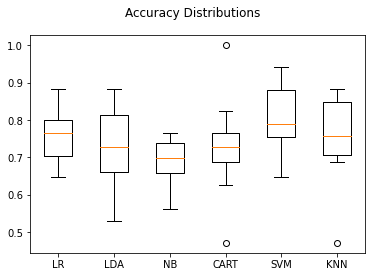

In [15]:
fig = pyplot.figure()
fig.suptitle('Accuracy Distributions')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

The fairly tight distribution for Logistic Regression suggests low variance, which is obviously very encouraging, but the fact that it outperformed KNN is a bit surprising.

It's possible that the varied distributions of the attributes revealed in the analysis phase is having an adverse effect on the accuracy of KNN, especially since many of them seemed to have Gaussian-like distributions.  Perhaps a re-evaluation with a standardized copy of the training data set is in order...

The data will be transformed so each attribute will have a mean value of zero and a standard deviation of one, and pipelines will be used to both standardize the data and build the model for each fold in the cross-validation test harness.  This will help us avoid data leakage and arrive at a fair estimation of how each model might perform on unseen data.

In [16]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier(random_state=seed))])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC(random_state=seed))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.771691 (0.080873)
ScaledLDA: 0.729412 (0.102602)
ScaledNB: 0.686397 (0.066034)
ScaledCART: 0.727941 (0.129201)
ScaledSVM: 0.854412 (0.103885)
ScaledKNN: 0.787132 (0.112856)


We can see that standardizing the data increased the accuracy of both the distance-based algorithms, with SVM emerging as the clear winner.

Once again, we'll examine the box and whisker plots of the accuracy distributions...

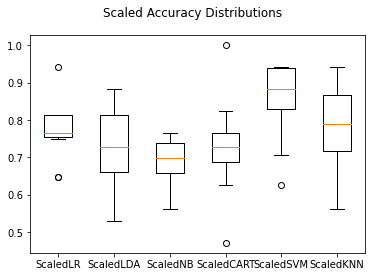

In [17]:
fig = pyplot.figure()
fig.suptitle('Scaled Accuracy Distributions')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [18]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
print("Default 'n_neighbors': %f" % model.n_neighbors)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Default 'n_neighbors': 5.000000
0.825000 (0.102602) with: {'n_neighbors': 1}
0.830515 (0.076792) with: {'n_neighbors': 3}
0.787132 (0.112856) with: {'n_neighbors': 5}
0.764338 (0.125059) with: {'n_neighbors': 7}
0.751838 (0.142657) with: {'n_neighbors': 9}
0.734191 (0.148350) with: {'n_neighbors': 11}
0.715809 (0.147032) with: {'n_neighbors': 13}
0.733456 (0.142316) with: {'n_neighbors': 15}
0.728309 (0.136014) with: {'n_neighbors': 17}
0.733456 (0.152901) with: {'n_neighbors': 19}
Best: 0.830515 using {'n_neighbors': 3}


It seems that the best accuracy can be achieved when n_neighbors is 3... 

Moving on to SVM, the two primary parameters of initial interest are the type of 'kernel' used, and how much the margin should be relaxed ('C').  As with KNN, a grid search using 10 fold cross validation with a standardized copy of the training data set will be performed.  A small set of kernel types and 'C' values with less and more bias will be tested...

In [19]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['rbf', 'sigmoid', 'linear', 'poly']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC(random_state=seed)
print("Default 'C': %f, Default 'kernel': %s" % (model.C, model.kernel))
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Default 'C': 1.000000, Default 'kernel': rbf
0.576103 (0.177875) with: {'C': 0.1, 'kernel': 'rbf'}
0.668015 (0.109100) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.765074 (0.089911) with: {'C': 0.1, 'kernel': 'linear'}
0.542279 (0.120611) with: {'C': 0.1, 'kernel': 'poly'}
0.756985 (0.150479) with: {'C': 0.3, 'kernel': 'rbf'}
0.710662 (0.110576) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.723529 (0.094132) with: {'C': 0.3, 'kernel': 'linear'}
0.597059 (0.141286) with: {'C': 0.3, 'kernel': 'poly'}
0.775735 (0.133167) with: {'C': 0.5, 'kernel': 'rbf'}
0.747059 (0.113386) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.765441 (0.091968) with: {'C': 0.5, 'kernel': 'linear'}
0.658456 (0.146916) with: {'C': 0.5, 'kernel': 'poly'}
0.830147 (0.135918) with: {'C': 0.7, 'kernel': 'rbf'}
0.747059 (0.103828) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.777574 (0.082278) with: {'C': 0.7, 'kernel': 'linear'}
0.741176 (0.144903) with: {'C': 0.7, 'kernel': 'poly'}
0.860662 (0.090972) with: {'C': 1.0, 'kernel': 'rbf'}
0.735

We can see that SVM was able to best KNN (87.9412% vs. 83.0515 %) with a 'C' of 2.0 and an RBF kernel.

Lastly, we'll compare our two front-runners against some ensemble methods.  Four will be evaluated, with two bagging and two boosting algorithms:

- Extra Trees
- Random Forests
- Gradient Boosting
- AdaBoost

The same 10 fold cross validation test harness will be used, but the training data won't be standardized in this case, since all four ensemble algorithms are based on decision trees that are less sensitive to data distributions...

In [20]:
ensembles = []
ensembles.append(('ET', ExtraTreesClassifier(random_state=seed)))
ensembles.append(('RF', RandomForestClassifier(random_state=seed)))
ensembles.append(('GBM', GradientBoostingClassifier(random_state=seed)))
ensembles.append(('AB', AdaBoostClassifier(random_state=seed)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ET: 0.866912 (0.065557)
RF: 0.807721 (0.093762)
GBM: 0.808456 (0.137546)
AB: 0.860662 (0.113857)


Extra Trees and AdaBoost both did very well, but not quite good enough to beat SVM...

Let's take a quick look at the accuracy distributions of the ensembles...

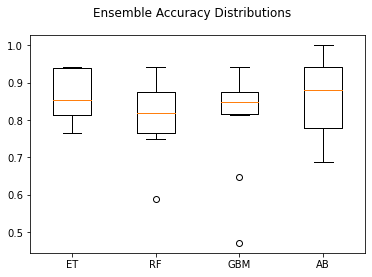

In [21]:
fig = pyplot.figure()
fig.suptitle('Ensemble Accuracy Distributions')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

The results suggest that Extra Trees may be worthy of further study, with a tighter distribution than AdaBoost, a slightly higher mean accuracy, and a spread that skews up above 90%...

What I find interesting about extra trees is that unlike random forest, extra trees fits each decision tree on the whole training dataset rather than developing each decision tree from a bootstrap sample of it.  It shares a characteristic of random forest, in that it will randomly sample the features at each split point of a decision tree, but unlike random forest, it selects split points at random instead of using a greedy algorithm.

Now, let's finalize the model by training our winning algorithm on the entire training dataset, and make predictions for the hold-out testing dataset to confirm our findings.  It was determined that SVM performs better when the data set is standardized, so we'll run the same transformation on the entire training data set...

In [22]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(random_state=seed, C=2.0)
model.fit(rescaledX, Y_train)
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8095238095238095
[[19  3]
 [ 5 15]]
              precision    recall  f1-score   support

           M       0.79      0.86      0.83        22
           R       0.83      0.75      0.79        20

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81        42



We're able to achieve an accuracy of almost 81% on the reserved testing data set, which falls a bit short of what we achieved against the training data set, but is still respectable.

## Insights & Analysis

At the conclusion of these initial rounds of algorithm evaluation, our winner is SVM, and it seems my initial intuition was shown to be correct, although further rounds of transformation, tuning, and evaluation could certainly lead to other conclusions...

What this project really reinforced for me was the relationship between algorithms and data preparation pipelines, and how the specific requirements and characteristics of various algorithms, along with the data insights gleaned from analysis, will drive the base requirements for the types of data cleaning, feature engineering, and transformation pipelines that will need to be used.  Domain knowledge obviously plays an important role as well, particularly in feature engineering, but clearly, the "minimum" requirements are driven largely by what the algorithms need to perform well.

With an eye toward formulating a general approach for evaluating algorithms in future projects, it seems like the rather broad approach of comparing a balanced basket of algorithms suitable for the specific type of machine learning problem at hand is rather sensible, even if a bit inefficient.  This appears to be a very appropriate trade-off to accept, simply because even the most experienced applied machine learning practitioners can have trouble predicting which will be best, so this was the approach taken in this project.  Over time, intuition can be expected to "sharpen", possibly resulting in relatively leaner "baskets".

With a little more time, and maybe some better hardware, I would have liked to give more attention to several aspects of the project...

The first is something I alluded to in the analysis phase, but ended up glossing over in this initial evaluation: reducing the skew of attribute distributions to possibly benefit the algorithms that do better with Gaussian distributions.  In terms of the algorithms used in this project, this would include LR, LDA, NB, and possibly even KNN.  I would most likely begin by exploring Box-Cox transformations for reducing skew, as well as log and root transformations for making non-Gaussian distributions look more Gaussian.

Another is obviously doing some hyperparameter tuning on the leading Extra Trees ensemble, as it's quite possible it could have beaten SVM with a little tuning.  Here, I'd probably start by tuning the number of features randomly sampled for each split point, as it's arguably the single most important parameter to tune, as is the case for Random Forest as well.

Lastly, I'd like to explore better ways of evaluating the relative performance of stochastic algorithms.  Setting the random_state is fine, but yields different models with different performance characteristics within a particular range if the seed value is changed.  In many cases, simply using the results produced by an arbitrarily chosen seed value might be fine, but in some cases this might not be sufficient, and a more active approach to managing the uncertainty of these algorithms might be warranted.  My initial intuition here is to explore the creation of an ensemble of models, each created with a different seed, so when predictions are made, the mean of all predictions will be returned.  I suspect some tuning will be necessary to find the smallest number of models that will minimize prediction variance.